**Execute the below cell directly – might take ~1min to import everything!**

In [ ]:
%pip install xxhash

In [1]:
%%time
import pickle, uproot
import pandas as pd
import numpy as np
import awkward as ak
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
mpl.rcParams.update({'font.size': 20})

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow import keras
from tensorflow.keras import layers, activations

CPU times: user 5.65 s, sys: 1.12 s, total: 6.77 s
Wall time: 11.9 s


In [2]:
hep.style.use("CMS")

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
#tf.debugging.set_log_device_placement(False)

In [6]:
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)
print(c.device)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
/job:localhost/replica:0/task:0/device:GPU:0


# Training NN jet tagger for L1

This part1 consists of the following steps:

1. Load L1 data from ROOT Ntuple input files (one entry = one jet) and preprocess them for ML usage
2. Train and evaluate an NN classifier
3. Check the signal efficiency & rate of "traditional" L1 seeds (the menu)
4. Compare the NN trigger to the L1 menu
5. Measure efficiencies wrt some offline object variables

# 1. Load L1 jet data, define signal and bkg and plot variables

Below are the data paths to the input jet Ntuples with the L1 jets:

In [7]:
#fname_sig = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/alobanov/run3/L1nano/ggHH2b2tau_130x_v12.root"
#fname_bkg = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/alobanov/run3/L1nano/v12/mc/SingleNeutrino_E-10_gun/SingleNeutrino_130X_L1NanoV12_None/231205_110830/SingleNeutrino_130X_L1NanoV12.root"
#fname = "/afs/cern.ch/work/s/sewuchte/public/jetTuple.root"
#fname = "/eos/user/p/pinkaew/research/btag_mlatl1t/preprocessing-scripts/data/jetTuple.root"
fname = "/eos/user/p/pinkaew/research/btag_mlatl1t/cms_mlatl1t_tutorial/part1/data/all_data.root"

We will be using [`uproot`](https://uproot.readthedocs.io/en/latest/index.html) and [`awkward arrays`](https://awkward-array.org/doc/main/) for reading the Nano ROOT files and manipulating the "jagged" arrays.

In [8]:
#f_sig = uproot.open(fname_sig)
#f_bkg = uproot.open(fname_bkg)
input_file = uproot.open(fname)

In [9]:
input_file["jetntuple/tree"].keys(filter_name="jet_*");

We will read all jet properties to use them in the NN training.

Below we will load the information using the `array` method of `awkward`. It accepts regexp for the branch name filter.

In [12]:
%%time
input_data = input_file["jetntuple/tree"].arrays(
#    filter_name = "/(jet)_(pt|eta|phi|bjetscore)/", 
    filter_name = "/(jet)_(eta|phi|pt|pt_raw|mass|energy|px|py|pz|bjetscore|reject|tauflav|muflav|elflav|taudecaymode|lepflav|taucharge|genmatch_pt|genmatch_eta|genmatch_phi|genmatch_mass|genmatch_hflav|genmatch_pflav|npfcand|pfcand_pt|pfcand_px|pfcand_py|pfcand_pz|pfcand_pt_log|pfcand_eta|pfcand_phi|pfcand_mass|pfcand_energy|pfcand_energy_log|pfcand_puppiweight|pfcand_z0|pfcand_dxy|pfcand_dxy_custom|pfcand_id|pfcand_charge|pfcand_pperp_ratio|pfcand_ppara_ratio|pfcand_deta|pfcand_dphi|pfcand_etarel|pfcand_track_chi2|pfcand_track_chi2norm|pfcand_track_qual|pfcand_track_npar|pfcand_track_nstubs|pfcand_track_vx|pfcand_track_vy|pfcand_track_vz|pfcand_track_pterror|pfcand_cluster_hovere|pfcand_cluster_sigmarr|pfcand_cluster_abszbarycenter|pfcand_cluster_emet|pfcand_cluster_egvspion|pfcand_cluster_egvspu)/", 
    #entry_stop = 1e1, 
    how = "zip"
)

KeyboardInterrupt: 

Note how each object is grouped in a respective field:

In [11]:
print(len(input_data))

1096189


In [12]:
input_data.fields;

And the pfcand variables are accesible at the next level (this is a result of using `how="zip"` when loading)

In [13]:
input_data.jet_pfcand.fields;

In [14]:
input_data = input_data[(input_data["jet_pt"] > 15) & (input_data["jet_pt"] < 1000) & (np.abs(input_data["jet_eta"]) < 2.4)]

In [16]:
print(len(input_data))

757351


In [17]:
def compute_selection_mask(events, selection_string):
    mask = None
    for sel_token in selection_string.split("&"):
        sign_match_obj = re.search(r"(>=|<=|==|!=|>|<|=)", sel_token)
        sign = sel_token[sign_match_obj.start(): sign_match_obj.end()]
        field = sel_token[:sign_match_obj.start()].strip()
        value = float(sel_token[sign_match_obj.end():].strip())
        
        if field in events.fields:
            field_array = events[field]
        else:
            if re.match("[a-zA-Z]+\(.+\)$", field):
                left_parenthesis_index = field.index("(")
                field_name = field[left_parenthesis_index+1:-1]
                func = field[:left_parenthesis_index]
                if func == "abs":
                    field_array = abs(events[field_name])
                else:
                    raise NotImplementedError("not implemented function: {}".format(func))
            else:
                raise ValueError("unrecognized field format: {}".format(field))        
        
        if sign == "=" or sign == "==":
            this_mask = (field_array == value)
        elif sign == ">":
            this_mask = (field_array > value)
        elif sign == "<":
            this_mask = (field_array < value)
        elif sign == ">=":
            this_mask = (field_array >= value)
        elif sign == "<=":
            this_mask = (field_array <= value)
        elif sign == "!=":
            this_mask = (field_array != value)
        else:
            raise ValueError("unrecognized sign: {}".format(sign))
                         
        if mask is None:
            mask = this_mask
        else:
            mask = mask & this_mask
    return mask

In [26]:
flavour_selection_dict = {
    "b": "jet_genmatch_pt> -1 & jet_muflav=0 & jet_tauflav = 0 & jet_elflav = 0 & jet_genmatch_hflav = 5",
    #"c": "jet_genmatch_pt> -1 & jet_muflav=0 & jet_tauflav = 0 & jet_elflav = 0 & jet_genmatch_hflav = 4",
    "g": "jet_genmatch_pt> -1 & jet_muflav=0 & jet_tauflav = 0 & jet_elflav = 0 & abs(jet_genmatch_pflav) = 21 & jet_genmatch_hflav = 0",
    "uds": "jet_genmatch_pt> -1 & jet_muflav=0 & jet_tauflav = 0 & jet_elflav = 0 & abs(jet_genmatch_pflav)  < 4 & abs(jet_genmatch_pflav) > 0",
    #"tau": "jet_muflav=0 & jet_elflav=0 & jet_tauflav=1",
    #"tau+": "jet_muflav=0 & jet_elflav=0 & jet_tauflav=1 & jet_taucharge>0",
    #"tau-": "jet_muflav=0 & jet_elflav=0 & jet_tauflav=1 & jet_taucharge<0",
}

In [27]:
flavour_mask_dict = {flavour: compute_selection_mask(input_data, flavour_selection) 
                     for flavour, flavour_selection in flavour_selection_dict.items()}

flavour_mask_unmatched = None
for flavour, flavour_mask in flavour_mask_dict.items():
    if flavour_mask_unmatched is None:
        flavour_mask_unmatched = flavour_mask
    flavour_mask_unmatched = flavour_mask_unmatched | flavour_mask

flavour_mask_dict["unmatched"] = ~flavour_mask_unmatched
flavour_mask_dict.keys()

dict_keys(['b', 'g', 'uds', 'unmatched'])

In [28]:
input_data_dict = {flavour:input_data[mask] for flavour, mask in flavour_mask_dict.items()}

In [29]:
for flavour, flavour_data in input_data_dict.items():
    print("falvour: {} length: {}".format(flavour, len(flavour_data)))

falvour: b length: 140391
falvour: g length: 123413
falvour: uds length: 149379
falvour: unmatched length: 344237


In [30]:
# # Definition of signal (b jets)

# condition_sig = (
#     (data['jet_genmatch_pt'] > -1) &
#     (data['jet_muflav'] == 0) &
#     (data['jet_tauflav'] == 0) &
#     (data['jet_elflav'] == 0) &
#     (data['jet_genmatch_hflav'] == 5)
# )

# data_sig = data[condition_sig]

# # Validation: check that signal only contains jets with hadron flavour 5
# jethflav = ak.to_numpy(data_sig['jet_genmatch_hflav'])
# flat_jethflav=jethflav.flatten()
# type(flat_jethflav)
# plt.hist(flat_jethflav, bins=np.arange(0, 10, 1), edgecolor='black')
# plt.title('Distribution of jet hadron flavour')
# plt.xlabel('jet_genmatch_hflav')
# plt.ylabel('Frequency')
# #hep.cms.label(data=False)
# plt.show()

In [31]:
# # Definition of background (non-b jets)
# condition_bkg = ~condition_sig

# data_bkg = data[condition_bkg]

# # Sanity check
# print("Length of data:    ", len(data))
# print("Length of data_sig:", len(data_sig))
# print("Length of data_bkg:", len(data_bkg))

To speed up the next steps, let us limit ourselves to 100k signal and 100k bkg jets:

In [32]:
Njets = 100000
# # Pick randomly 100k signal jets
# random_indices_sig = np.random.choice(len(data_sig), size=Njets, replace=False)
# data_sig = data_sig[random_indices_sig]
# print("Length of data_sig now:", len(data_sig))
# # Pick randomly 100k bkg jets
# random_indices_bkg = np.random.choice(len(data_bkg), size=Njets, replace=False)
# data_bkg = data_bkg[random_indices_bkg]
# print("Length of data_bkg now:", len(data_bkg))


data_dict = dict()
for flavour, flavour_data in input_data_dict.items():
    random_indices = np.random.choice(len(flavour_data), size=Njets, replace=False)
    data_dict[flavour] = flavour_data[random_indices ]
    
for flavour, flavour_data in data_dict.items():
    print("falvour: {} length: {}".format(flavour, len(flavour_data)))

falvour: b length: 100000
falvour: g length: 100000
falvour: uds length: 100000
falvour: unmatched length: 100000


In [33]:
# Look at the structure of data
data_dict["b"].type

100000 * {"jet_eta": float32, "jet_phi": float32, "jet_pt": float32, "jet_pt_raw": float32, "jet_mass": float32, "jet_energy": float32, "jet_px": float32, "jet_py": float32, "jet_pz": float32, "jet_bjetscore": float32, "jet_reject": bool, "jet_tauflav": int32, "jet_muflav": int32, "jet_elflav": int32, "jet_taudecaymode": int32, "jet_lepflav": int32, "jet_taucharge": int32, "jet_genmatch_pt": float32, "jet_genmatch_eta": float32, "jet_genmatch_phi": float32, "jet_genmatch_mass": float32, "jet_genmatch_hflav": uint32, "jet_genmatch_pflav": int32, "jet_npfcand": uint32, "jet_pfcand": var * {"pt": float32, "px": float32, "py": float32, "pz": float32, "pt_log": float32, "eta": float32, "phi": float32, "mass": float32, "energy": float32, "energy_log": float32, "puppiweight": float32, "z0": float32, "dxy": float32, "dxy_custom": float32, "id": uint32, "charge": int32, "pperp_ratio": float32, "ppara_ratio": float32, "deta": float32, "dphi": float32, "etarel": float32, "track_chi2": float32, "t

### Important: in DATA one has to only filter on `bx=0` for proper usage!
Below is an example of how this can be achieved:

We shall filter the `bx=0` L1 objects from the events -> need to add `bx` to the array reading step above.

```python
data_bkg_allBX = data_bkg

bx = 0
data_bkg_bx0 = {}

for obj in data_bkg_allBX.fields:
    # make a mask to filter out bx=0 only
    bx_mask = data_bkg_allBX[obj].bx == bx
    data_bkg_bx0[obj] = data_bkg_allBX[obj][bx_mask]
    
data_bkg = ak.Array(data_bkg_bx0)
```

## Inspect input data / plot distributions

First, let's inspect the variables we are going to use. 

We will start with the jet constituent (pfcand) multiplicities:

In [34]:
for obj in ['jet_pfcand']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        num = ak.num(data[obj])
        plt.hist(num, label = label, bins = range(30), density = True, 
                 #log = True, 
                 histtype = "step")
        
    plt.xlabel(f"N of {obj}")
    plt.legend()
#     plt.grid()

NameError: name 'data_bkg' is not defined

<Figure size 432x288 with 0 Axes>

Let us also plot the PUPPI weight of the leading-pt constituent:

In [ ]:
for obj in [ 'jet_pfcand']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        # notice the [:,:1] below -> we slice the array and select no more than the first entry per event
        # ak.ravel makes the array flat such that we can fill a histogram
        plt.hist(ak.ravel(data[obj].puppiweight[:,:1]), label = label, bins = 50, density = True, 
                 log = True, 
                 histtype = "step")
        
    plt.xlabel(f"{obj} puppiweight")
    plt.legend()
#     plt.grid()

There surely is some discrimation power in these variables! :)

Let's move over to the ML part, though we first need to preprocess the data / convert it into a flat format

### Convert data to regular array for ML usage

Due to the variable number of objects per event (except for the sums) we need to convert the data from the jagged format to a tabular (regular) format with the rows corresponding to events and the columns to the variables. 

For that we have to pick:
1. An order of objects e.g. Sums, Jets, EG, Muons
2. The variables for each
3. The max number of objects we want to use
4. The values to use to pad empty objects

We can write this down in the following dictionary:

In [35]:
# All PF candidate properties
pfcand_fields_all = ['pt','px','py','pz','pt_log','eta','phi','mass','energy','energy_log','puppiweight','z0','dxy','dxy_custom','id','charge','pperp_ratio','ppara_ratio','deta','dphi','etarel','track_chi2','track_chi2norm','track_qual','track_npar','track_nstubs','track_vx','track_vy','track_vz','track_pterror','cluster_hovere','cluster_sigmarr','cluster_abszbarycenter','cluster_emet','cluster_egvspion','cluster_egvspu']
# A slightly reduced set
pfcand_fields = ['pt_log','eta','energy_log','puppiweight','z0','dxy_custom','id','pperp_ratio','ppara_ratio','deta','dphi','etarel','track_chi2norm','track_qual','track_nstubs','track_vx','track_vy','track_vz','track_pterror','cluster_hovere','cluster_sigmarr','cluster_abszbarycenter','cluster_emet']
pfcand_fields = ['eta','puppiweight','z0','dxy_custom','id','pperp_ratio','ppara_ratio','deta','dphi','etarel','track_chi2norm','track_qual','track_nstubs','track_vx','track_vy','track_vz','track_pterror','cluster_hovere','cluster_sigmarr','cluster_abszbarycenter','cluster_emet']
objects = [
#    {"name" : "jet", "key" : "L1Jet", "fields" : ["pt", "eta", "phi"], "n_obj" : 8},
    {"name" : "pfcand", "key" : "jet_pfcand", "fields" : pfcand_fields, "n_obj" : 16},
]

We will use dedicated functions to ease this conversion from jagged to regular format.

These functions are taken from the end-to-end ML@L1 framework of the TOPO team:
(authors: `@flabe` and `@alobanov`)

https://gitlab.cern.ch/uhh-l1t/uhh_mlatl1_run3 

In [36]:
def getPadNParr(events, obj, n_pad, fields, cuts = None, name = None, pad_val = 0):
    '''
    This function filter objects and pads them to a certain length with a given value
    '''
    
    objects = events[obj]
    
    if not name: name = obj
    
    # cuts are defined as a dictionary containing the relevant keys:
    # cuttype, field and value
    if cuts:
        for cut in cuts:
            if cut["cuttype"] == "equals": objects = objects[objects[cut["field"]] == cut["value"]]
            else: raise Exception("Cuttype {} is not implemented.".format(cut["cuttype"]))
    
    pad_arrs = []
    var_names = []
        
    # padding with nones
    pad_arr = ak.pad_none(objects, n_pad, clip=True)
    
    # combining to numpy
    for i in range(n_pad):

        for var in fields:
            pad_arrs += [ak.to_numpy( ak.fill_none(pad_arr[var][:,i], pad_val) )]
            var_names.append( "{}_{}_{}".format(name, i, var) )
            
    return np.stack(pad_arrs), var_names

def formatDataTopotrigger(data, objects, verbosity = 0):
    '''
    This function concatenates the padded arrays for different objects.
    It is controlled via a dictionary as defined above
    '''
    
    # this will be filled by all required objects
    dataList = [] 
    varList = []
    
    for obj in objects: 
        dat, names = getPadNParr(data, obj["key"], obj["n_obj"], obj["fields"], obj["cuts"] if "cuts" in obj else None, obj["name"] )
        dataList.append(dat)
        varList += names
        
    if verbosity > 0:
        print("The input variables are the following:")
        print(varList)
                
    # combining and returning (and transforming back so events are along the first axis...)
    return np.concatenate(dataList, axis = 0).T, varList


Let's first convert the signal data: 

In [37]:
x_dict = {flavour: formatDataTopotrigger(data, objects, verbosity = 0)[0] for flavour, data in data_dict.items()}

In [38]:
#x_sig, var_names = formatDataTopotrigger(data_sig, objects, verbosity = 99)

In [39]:
x_dict["b"].shape

(100000, 336)

You can see that we have ~100k events and 368 variables.
Let us do the same for the background sample:

In [40]:
#x_bkg, var_names = formatDataTopotrigger(data_bkg, objects, verbosity = 0)

In [41]:
#x_bkg.shape

And now we can compare the distributions of the input features. 
We will focus on the leading objects only:

In [42]:
for i,name in enumerate(var_names[:100]):
    if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x_bkg[:,i], bins = 50, log = True, density = True, label = "Bkg")
    _ = plt.hist(x_sig[:,i], bins = _[1], histtype = "step", density = True, label = "Sig")
    
    plt.xlabel(name)
    plt.legend()
    plt.show()
    plt.close()
#     break

NameError: name 'var_names' is not defined

You can see now that for the non-sum objects we have peaks at 0 as this was the `pad_val` padding value for filling empty variables.

### Final preprocessing: concatenating sig/bkg, scaling and train/test splitting

Finally, we have to concatenate the signal and background arrays:

In [43]:
# creating labels
# y_bkg = np.zeros(len(x_bkg))
# y_sig = np.ones(len(x_sig))

y_dict = {flavour:(index+1)*np.ones(len(x_dict[flavour])) 
          if flavour != "unmatched" else np.zeros(len(x_dict[flavour])) 
          for index, flavour in enumerate(x_dict.keys())}

In [44]:
x = np.concatenate(tuple(x_dict.values()))
y = np.concatenate(tuple(y_dict.values()))
y = tf.keras.utils.to_categorical(y)

In [45]:
for flavour in x_dict.keys():
    print(flavour, len(x_dict[flavour]), len(y_dict[flavour]))

b 100000 100000
g 100000 100000
uds 100000 100000
unmatched 100000 100000


Then, we need to scale / normalise the inputs to be able to use them together in the NN training

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(x)
x_scaled = scaler.transform(x)

We will save the scaler and data for the next parts:

In [47]:
# make directory
outdir = "part1_outputs_multijettagging/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [48]:
with open(outdir+"scaler.pkl", 'wb') as file_pi: 
    pickle.dump(scaler, file_pi)

And split dataset to train/test samples

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)

We will save the train/test data now using awkward's `to_parquet` function:

In [50]:
ak.to_parquet(X_train, outdir+"X_train_scaled.parquet")
ak.to_parquet(y_train, outdir+"y_train_scaled.parquet")

In [51]:
ak.to_parquet(X_test, outdir+"X_test_scaled.parquet")
ak.to_parquet(y_test, outdir+"y_test_scaled.parquet")

In [52]:
! ls -lthr part1_outputs_btagging

total 190M
-rw-r--r--. 1 pinkaew 1399 8.4K Dec 14 11:44 scaler.pkl
-rw-r--r--. 1 pinkaew 1399  95M Dec 14 11:44 X_train_scaled.parquet
-rw-r--r--. 1 pinkaew 1399  14K Dec 14 11:44 y_train_scaled.parquet
-rw-r--r--. 1 pinkaew 1399  95M Dec 14 11:44 X_test_scaled.parquet
-rw-r--r--. 1 pinkaew 1399  14K Dec 14 11:44 y_test_scaled.parquet
-rw-r--r--. 1 pinkaew 1399  59K Dec 14 12:05 model.h5
-rw-r--r--. 1 pinkaew 1399  61K Dec 14 12:05 history.pkl
-rw-r--r--. 1 pinkaew 1399 598K Dec 14 12:06 y_test_pred.parquet


In [ ]:
#X_train = ak.from_parquet(outdir+"X_train_scaled.parquet").to_numpy()
#y_train = ak.from_parquet(outdir+"y_train_scaled.parquet").to_numpy()
#X_test = ak.from_parquet(outdir+"X_test_scaled.parquet").to_numpy()
#y_test = ak.from_parquet(outdir+"y_test_scaled.parquet").to_numpy()

These files can be read with `ak.read_parquet("filename.parquet")` afterwards.

# 2. Train NN classifier

Now we can move one to the NN training. 
We will use a simple fully-connected 3 layer network with 64/32/32 nodes following the HLS4ML tutorial: https://github.com/fastmachinelearning/hls4ml-tutorial/blob/main/part1_getting_started.ipynb

In [94]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='gelu', name='gelu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='gelu', name='gelu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='gelu', name='gelu3'))
model.add(Dense(len(y_dict.keys()), name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='sigmoid', name='sigmoid'))

In [95]:
adam = Adam(learning_rate=5e-4)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [96]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 64)                21568     
                                                                 
 gelu1 (Activation)          (None, 64)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                2080      
                                                                 
 gelu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 gelu3 (Activation)          (None, 32)                0         
                                                                 
 output (Dense)              (None, 4)                

Next, we will train the model with 10 epochs and record the history

In [97]:
X_train.shape

(320000, 336)

In [98]:
y_train.shape

(320000, 4)

In [99]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)]

In [100]:
%%time
history = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=100,
    validation_split=0.20,
    shuffle=True,
    callbacks=[callbacks],
)

Epoch 1/100
250/250 [==============================] - 4s 8ms/step - loss: 1.3533 - accuracy: 0.4410 - val_loss: 1.2852 - val_accuracy: 0.4775
Epoch 2/100
250/250 [==============================] - 1s 6ms/step - loss: 1.2568 - accuracy: 0.4894 - val_loss: 1.2344 - val_accuracy: 0.4976
Epoch 3/100
250/250 [==============================] - 2s 6ms/step - loss: 1.2176 - accuracy: 0.5031 - val_loss: 1.2069 - val_accuracy: 0.5067
Epoch 4/100
250/250 [==============================] - 1s 6ms/step - loss: 1.1974 - accuracy: 0.5077 - val_loss: 1.1925 - val_accuracy: 0.5104
Epoch 5/100
250/250 [==============================] - 1s 6ms/step - loss: 1.1850 - accuracy: 0.5116 - val_loss: 1.1826 - val_accuracy: 0.5130
Epoch 6/100
250/250 [==============================] - 1s 6ms/step - loss: 1.1762 - accuracy: 0.5142 - val_loss: 1.1751 - val_accuracy: 0.5157
Epoch 7/100
250/250 [==============================] - 1s 6ms/step - loss: 1.1701 - accuracy: 0.5154 - val_loss: 1.1698 - val_accuracy: 0.5165

We will save the model and history too:

In [101]:
model.save(outdir + "/model.h5")

with open(outdir + "/history.pkl", 'wb') as file_pi: pickle.dump(history, file_pi)

In [102]:
#from keras.models import load_model
#model = load_model(outdir + "/model.h5")

In [103]:
#with open(outdir + "/history.pkl", "rb") as f:
#    history = pickle.load(f)

Below is a convenience function to plot the training history

In [104]:
def plotTrainingHistory(history, metrics = ["loss", "accuracy"], f = None, axs = None):
    
    # creating the plot
    if not f and not axs:
        f, axs = plt.subplots(len(metrics), 1, figsize = (12, 4*len(metrics)), sharex = True)
    if len(metrics) == 1:
        axs = [axs]
    plt.subplots_adjust(wspace=0, hspace=0)

    # labeling
#     hep.cms.label("private work", data=False, ax=axs[0])

    for i in range(len(metrics)):
        
        metric = metrics[i]
        ax = axs[i]
        ax.set_ylabel(metric)
        
        if isinstance(history, list): # handle kfold
            for foldi in range(len(history)):
                ax.plot(history[foldi].history[metric], color = "C{}".format(foldi))
                ax.plot(history[foldi].history['val_' + metric], color = "C{}".format(foldi), linestyle = "--")
                
            la2, = ax.plot([0,0], [0,0], color="Grey")
            lb2, = ax.plot([0,0], [0,0], color="Grey", linestyle = "--")
            ax.legend([la2, lb2], ["training", "validation"])
        else: 
            xs = np.arange(len(history.history['val_' + metric]))
            ax.plot(xs,history.history[metric], label = 'training')
            ax.plot(xs+.5, history.history['val_' + metric], label= 'validation')
            ax.legend()

    axs[-1].set_xlabel("Epoch")
    
    return f, axs


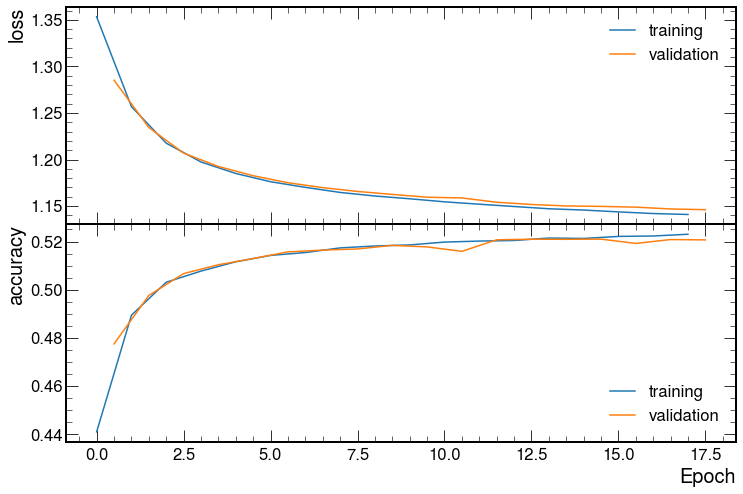

In [105]:
fig = plotTrainingHistory(history)

~~We can see that the model converges nicely and does not seem to overtrain.~~

### Make ROC

Next, we will make a ROC curve for the test dataset:

In [106]:
%%time
y_test_pred = model.predict(X_test)

2500/2500 [==============================] - 5s 2ms/step
CPU times: user 7.22 s, sys: 1.3 s, total: 8.52 s
Wall time: 7.36 s


In [107]:
# Save predictions:
ak.to_parquet(y_test_pred, outdir+"y_test_pred.parquet")

In [125]:
from scipy.special import softmax
y_test_prob = softmax(y_test_pred, axis=1)
y_test_prob

array([[0.21531929, 0.29319078, 0.19414788, 0.29734206],
       [0.22341822, 0.29180378, 0.18635212, 0.29842588],
       [0.19909209, 0.30996287, 0.21144111, 0.27950397],
       ...,
       [0.2656508 , 0.1942378 , 0.2846872 , 0.25542414],
       [0.28244457, 0.18848315, 0.28873733, 0.24033496],
       [0.21447942, 0.30272645, 0.18594418, 0.29684994]], dtype=float32)

In [134]:
y_dict

{'b': array([1., 1., 1., ..., 1., 1., 1.]),
 'g': array([2., 2., 2., ..., 2., 2., 2.]),
 'uds': array([3., 3., 3., ..., 3., 3., 3.]),
 'unmatched': array([0., 0., 0., ..., 0., 0., 0.])}

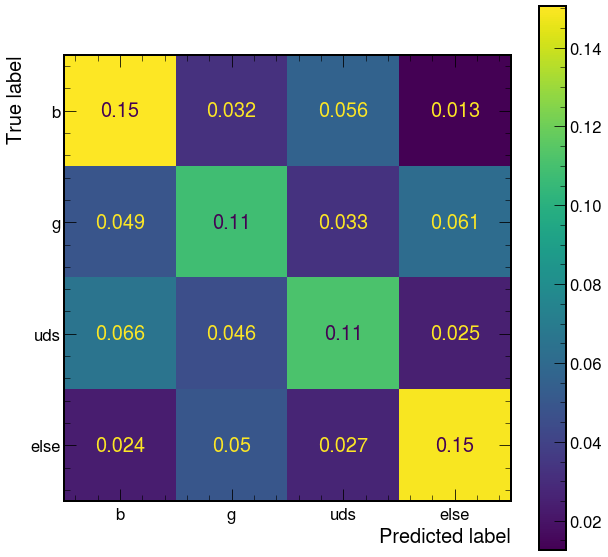

In [144]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), 
                                        np.argmax(y_test_prob, axis=1),
                                        labels=[1, 2, 3, 0],
                                        display_labels=["b", "g", "uds", "else"],
                                        normalize="all",
                                        ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_test_pred, drop_intermediate=False)

In [ ]:
plt.plot(fpr, tpr)
plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
plt.grid()

In [ ]:
# b-jet vs udsg ROC curve

bscore = ak.concatenate([data_sig.jet_bjetscore, data_bkg.jet_bjetscore])
whichjet = np.concatenate([np.ones(len(data_sig)), np.zeros(len(data_bkg))])

fpr0, tpr0, thr = roc_curve(whichjet, bscore, drop_intermediate=False)

In [ ]:
plt.plot(tpr, fpr, label="our MLP")
plt.plot(tpr0, fpr0, label="Fast PUPPI")
plt.xlabel("signal efficiency")
plt.ylabel("background efficiency")
plt.yscale("log")
plt.ylim(1e-3, 1)
plt.legend()
hep.cms.label(label="Private Work", data=False, rlabel="(14 TeV)")
plt.grid()

The AUC seems incredibly high! 

Though remember that at the L1 trigger level we look for reduction factors 1e4 (40 MHz -> 1 kHz), i.e. the FPR of interest lies much lower.

Much more practical is the rate in [k]Hz. In order to compute it we need to multiply the FPR with the LHC revolution frequency ~11kHz and the number of colliding bunches. The later can be looked up in the [Fill Report on OMS](https://cmsoms.cern.ch/cms/fills/report?cms_fill=9043) and is normally about 2500.

In [ ]:
## for L1 rate estimates from ZeroBias/SingleNuMC
def totalMinBiasRate(nCollBunch = 2500):
    LHCfreq = 11245.6
    return LHCfreq * nCollBunch / 1e3 # in kHz

Let's now make the ROC plot and focus on a rate range 0-100 kHz:

In [ ]:
plt.plot(fpr * totalMinBiasRate(), tpr, label="our MLP")
plt.plot(fpr0 * totalMinBiasRate(), tpr0, label="Fast PUPPI")
plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("TPR: signal efficiency")
plt.grid()
plt.xlim(0,120)
plt.legend()

## <font color='red'>End of Santeri's updates for jet tagging!</font>
## <font color='red'>End of Patin's updates for jet tagging!</font>

## 2. bis: Hardware input values

The uGT/FPGA firmware does not actually use the float variables as we did above. Instead, more hardware efficient integer values are used, called "hardware" (HW) variables. This is important when moving towards implementing the ML model in the actual FW -> ideally the training has to be done already with the HW features. 

Below we will load the HW representations of the features used above and compare them.

In [ ]:
%%time
data_sig_hw = f_sig["Events"].arrays(
    filter_name = "/(L1Mu|L1EG|L1Jet|L1EtSum)_(hwPt|hwEta|hwPhi|etSumType)/", 
#     entry_stop = 1e1, 
    how = "zip"
)

In [ ]:
%%time
data_bkg_hw = f_bkg["Events"].arrays(
    filter_name = "/(L1Mu|L1EG|L1Jet|L1EtSum)_(hwPt|hwEta|hwPhi|etSumType)/", 
#     entry_stop = 1e1, 
    how = "zip"
)

Note that we will define a dedicated HW object dictionary for the conversion to the tabular format:

In [ ]:
hw_objects = [
    {"name" : "MET", "key" : "L1EtSum", "fields" : ["hwPt", "hwPhi"], "n_obj" : 1,
     "cuts" : [{"cuttype" : "equals", "field" : "etSumType", "value" : 2}] },  # etSumType 2 = MET noHF
    {"name" : "jet", "key" : "L1Jet", "fields" : ["hwPt", "hwEta", "hwPhi"], "n_obj" : 8},
    {"name" : "eg", "key" : "L1EG", "fields" : ["hwPt", "hwEta", "hwPhi"], "n_obj" : 8},
    {"name" : "muon", "key" : "L1Mu", "fields" : ["hwPt", "hwEta", "hwPhi"], "n_obj" : 2},
]

In [ ]:
x_sig_hw, hw_var_names = formatDataTopotrigger(data_sig_hw, hw_objects, verbosity = 0)

In [ ]:
x_bkg_hw, hw_var_names = formatDataTopotrigger(data_bkg_hw, hw_objects, verbosity = 0)

In [ ]:
x_bkg_hw.shape, x_bkg.shape

In [ ]:
# combining signal & bkg
x_hw = np.concatenate((x_bkg_hw, x_sig_hw))

Let us compare the float and int/HW values:

In [ ]:
for i,name in enumerate(var_names[:10]):
    if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x[:,i], bins = 50, log = True, density = True, label = "float")
    _ = plt.hist(x_hw[:,i], bins = 50, histtype = "step", density = True, label = "int/hw")
    
    plt.xlabel(name)
    plt.legend()
#     break

Now we will will prepare a separate scaler for the HW values, and then we will save it for "Part 3" of this tutorial.

In [ ]:
hwScaler = StandardScaler()
_ = hwScaler.fit(x_hw)
x_hw_scaled = hwScaler.transform(x_hw)

In [ ]:
with open(outdir+"hwScaler.pkl", 'wb') as file_pi: 
    pickle.dump(hwScaler, file_pi)

And now we can compare the scaled values:

In [ ]:
for i,name in enumerate(var_names[:100]):
    if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x_scaled[:,i], bins = 50, log = True, density = True, label = "float")
    _ = plt.hist(x_hw_scaled[:,i], bins = 50, histtype = "step", density = True, label = "int/hw")
    
    plt.xlabel(name)
    plt.legend()
#     break

Note that except for phi the scaled float and int/HW value distributions match rather nice.
The mismatches for pt/eta are mostly due to rounding effects, whereas for phi the "issue" is that the HW phi 0 value corresponds to -pi and hence the zero-padding results in an asymmetric distribution, unlike for the float variables.

Since the phi variables do not contribute much to the NN performance, we can for now ignore this inconsistency. In an actual application it is advisable to train the ML with HW variables directly though!

# 3. Study current L1 menu

The idea is to look at the acceptance (trigger efficiency) of the current L1 menu for our signal of interest

### Get list of unprescaled L1 seeds

We will load the prescale table from a recent menu e.g. https://github.com/cms-l1-dpg/L1MenuRun3/blob/master/official/L1Menu_Collisions2023_v1_2_0/PrescaleTable/L1Menu_Collisions2023_v1_2_0.csv
(click on `RAW` view for the raw url to be used below)

In [ ]:
# this is the Prescale (PS) table that was used for the MC generation:
# l1_ps_url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/development/L1Menu_Collisions2022_v1_3_0/PrescaleTable/L1Menu_Collisions2022_v1_3_0.csv"

## official PS table for 2023 
# l1_ps_url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/official/L1Menu_Collisions2023_v1_2_0/PrescaleTable/L1Menu_Collisions2023_v1_2_0.csv"

## special PS table with backup seeds disabled for 1.9E34 column -> will use that one
l1_ps_url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/development/L1Menu_Collisions2023_v1_2_0/PrescaleTable/L1Menu_Collisions2023_v1_2_0-DedicatedPureRateStudy.csv"
df_l1_ps = pd.read_csv(l1_ps_url)
df_l1_ps.head()

Select unprescaled seeds (=`1`) for column "1p9E34" (this is a special PS table where backup seeds are disabled in this column)

In [ ]:
# filter PS column
mask = df_l1_ps["2p0E34"] == 1
# mask = df_l1_ps["1p9E34"] == 1 # for special no-backup column
l1_unps_seeds = df_l1_ps[mask].Name.values
print(f"We selected {len(l1_unps_seeds)} out of {len(df_l1_ps)} L1 seeds.")

### Load L1 seeds from the signal MC file

In [ ]:
%%time
bits_sig = f_sig["Events"].arrays(filter_name = l1_unps_seeds, entry_stop = 1e7)

In [ ]:
len(bits_sig.fields)

One can see that while we expected 161 seeds, only 178 were loaded -> the missing were not in the menu used for the MC production!

In [ ]:
# convert to a pandas dataframe for convenience
df_bits_sig = ak.to_dataframe(bits_sig) # might be to_pandas if using awkward < v2
df_bits_sig.head()

Now we will compute the total number of counts and in addition the number of pure counts i.e. where only one seed has fired

In [ ]:
%%time
counts = {}

for seed in df_bits_sig.columns:
    counts[seed] = {
        "total": df_bits_sig[seed].sum(), 
        "pure" :  (df_bits_sig[seed] & ~df_bits_sig.drop(seed, axis=1).any(axis=1)).sum(),
}
    
df_counts = pd.DataFrame(counts).T

In [ ]:
df_counts.sort_values("total", ascending = False)[:10]

Note that when we sort the seeds by the total counts as above we do have some high-count seeds with very low pure rate: these are in the "shadow" of other seeds when looking at this signal MC sample (but not necessarily on Background MC/ZeroBias!)

We will exlcude the seeds with low pure rate and sort by total again:

In [ ]:
df_counts_pure = df_counts[df_counts.pure > 0]
df_counts_pure.sort_values("total", ascending = False)[:5]

In [ ]:
len(df_counts_pure) # to check number of remaining seeds

Now we can compute the signal efficiencies by dividing the counts by the number of events

In [ ]:
df_eff_pure = df_counts_pure/len(bits_sig)

In [ ]:
df_eff_pure.sort_values("total", ascending = False)[:5]

In [ ]:
# # uncomment below to make a plot of the efficiencies
# ax = df_eff_pure.sort_values("total", ascending = True).plot(kind = "barh", figsize = (10,12))
# # ax.set_xscale("log")
# ax.set_xlabel("Signal efficiency")
# ax.grid()

### Rates for the unprescaled seeds using the background sample

We will use the above background dataset and only load the pure seeds we selected above for speed/performance.

In [ ]:
%%time
bits_bkg = f_bkg["Events"].arrays(filter_name = df_counts_pure.index.values, entry_stop = 1e7)

In [ ]:
%%time
df_bits_bkg = ak.to_dataframe(bits_bkg) # might be to_pandas if using awkward < v2

In [ ]:
%%time
counts_bkg = {}

df = df_bits_bkg

for seed in df.columns:
#     print(seed)
    counts_bkg[seed] = {
        "total": df[seed].sum(), 
        "pure" :  (df[seed] & ~df.drop(seed, axis=1).any(axis=1)).sum(),

}
    
df_counts_bkg = pd.DataFrame(counts_bkg).T

In [ ]:
df_counts_bkg.sort_values("total", ascending = False)[:10]

We convert the counts to the rate using the total minbias rate we defined above:

In [ ]:
df_rate_bkg = df_counts_bkg * totalMinBiasRate() / len(bits_bkg)

In [ ]:
df_rate_bkg.sort_values("total", ascending = False)[:10]

You might notice that the rates are much lower than usually quoted. This is not only due to data/MC differences, but also due to the fact that here in MC we consider a wide PU range.

Only for reference: rates from OMS: https://cmsoms.cern.ch/cms/triggers/l1_rates?cms_run=370293&update=false

We can merge the signal efficiency and (background) rate dataframes for convenience:

In [ ]:
df_eff_rate = df_eff_pure.join(df_rate_bkg, lsuffix = " eff", rsuffix = " rate")
df_eff_rate.sort_values("total eff", ascending = False)[:5]

Now we can make a "ROC" curve from the signal efficiency and rates for the L1 seeds.
For this we will first selecte the 5 "best" triggers for plotting:

In [ ]:
best_trigs = list(df_eff_pure.sort_values("total", ascending = False)[:5].index)
best_trigs

In [ ]:
plt.figure(figsize = (10,6))

for trig in best_trigs:
    eff = df_eff_rate.loc[trig,"total eff"]
    rate = df_eff_rate.loc[trig,"total rate"]
    print(trig, eff, rate)
    
    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
plt.legend(fontsize = 15)
plt.ylim(0,1)
# plt.xlim(0,)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

# 4. Compare NN vs L1 seeds

Finally, we can compare the NN and L1 menu triggers in one plot:

In [ ]:
plt.figure(figsize = (12,8))
plt.title("HH>bbtautau")

for trig in best_trigs:
    eff = df_eff_rate.loc[trig,"total eff"]
    rate = df_eff_rate.loc[trig,"total rate"]
    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
    
plt.plot(fpr * totalMinBiasRate(), tpr , label = "NN trigger")
    
plt.xlim(0,20)
plt.legend(fontsize = 15)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

We can also add the OR of the full L1 menu and of the best triggers:

In [ ]:
bits = np.concatenate((bits_bkg, bits_sig))

In [ ]:
all_trig_or = False

for trig in bits.fields:
    all_trig_or = all_trig_or | bits[trig]

In [ ]:
best_bits_or = False

for trig in best_trigs:
    best_bits_or = best_bits_or | bits[trig]

In [ ]:
# Make a "ROC" curve from the signal efficiency and rates

plt.figure(figsize = (12,8))
plt.title("HH>bbtautau")

for trig in best_trigs:
    
    eff = df_eff_pure.loc[trig,"total"]
    rate = df_rate_bkg.loc[trig,"total"]
#     print(trig, eff, rate)
    
    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
## total L1 menu
eff = np.sum(all_trig_or[y==1]) / np.sum(y==1)
rate = np.sum(all_trig_or[y==0]) / np.sum(y==0) * totalMinBiasRate()
plt.plot(rate, eff, "o", label = "All L1", ms = 10)
    
plt.plot(fpr * totalMinBiasRate(), tpr , label = "NN trigger")
    
plt.xlim(0,50)
plt.legend(fontsize = 15)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

Note that the `All L1` menu rate is unrealistic since the MC PU profile is lower than what the considered menu was designed for!

**Bonus**: we can also make a ROC curve for the L1 HT variable to check if we could lower the HT threshold and compare to the NN ROC.

For this we first need to extract the L1 HT from the data:

In [ ]:
# L1 l1ht
l1ht_sig = data_sig.L1EtSum[data_sig.L1EtSum["etSumType"] == 1].pt[:,0]
l1ht_bkg = data_bkg.L1EtSum[data_bkg.L1EtSum["etSumType"] == 1].pt[:,0]
l1ht_all = np.concatenate([l1ht_bkg,l1ht_sig])

In [ ]:
_ = plt.hist(l1ht_bkg, bins = np.linspace(0,500,50), log = True, density = 1,)
_ = plt.hist(l1ht_sig, bins = _[1], histtype = "step", density = 1,)
plt.xlabel("L1 HT")

Make the HT "ROC"

In [ ]:
ht_fpr, ht_tpr, ht_thr = roc_curve(y, l1ht_all, drop_intermediate=False)
# plt.plot(ht_fpr, ht_tpr)

In [ ]:
plt.figure(figsize = (12,8))
plt.title("HH>bbtautau")

for trig in best_trigs:
    eff = df_eff_pure.loc[trig,"total"]
    rate = df_rate_bkg.loc[trig,"total"]

    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
## total L1 menu
eff = np.sum(all_trig_or[y==1]) / np.sum(y==1)
rate = np.sum(all_trig_or[y==0]) / np.sum(y==0) * totalMinBiasRate()
plt.plot(rate, eff, "o", label = "All L1", ms = 10)

## HT ROC
plt.plot(ht_fpr * totalMinBiasRate(), ht_tpr, label = "HT thr scan")
    
## NN
plt.plot(fpr * totalMinBiasRate(), tpr , label = "NN trigger")
  
plt.xlim(0,50)
# plt.xlim(1,1e3)
# plt.xscale("log")

plt.legend(fontsize = 15)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

You can see that the `L1_HTT280er` seed point lies exactly on the HT scan curve which is a good cross-check.

Finally, the NN always outperforms the L1 Menu, even when all the seeds are combined.

# 5. Offline Efficiencies

In this part we will look into the trigger efficiencies with respect to some offline quantities such as MET and HT. 

This will help to see in which phase-space the NN trigger outperforms the traditional seeds.

We first need to load the offline Jets and MET for the signal:

In [ ]:
%%time
f_sig = uproot.open(fname_sig)
events_sig = f_sig["Events"].arrays(
    filter_name = ["/Jet_(pt|eta|phi|jetId)/", "MET_pt"],
#     entry_stop = 1,
    how = "zip", 
)

We will now compute the HT from jets with pt > 30, eta < 2.4 and jetId>=2

In [ ]:
jets = events_sig.Jet
jets["mass"] = 0

jets_mask = (jets.pt > 30) & (abs(jets.eta) < 2.4) & (events_sig.Jet.jetId >= 2)
good_jets = ak.Array(jets[jets_mask], with_name = "Momentum4D")

ht_sig = ak.fill_none(ak.sum(good_jets.pt, axis = 1), 40)

We will plot the distribution of offline HT and then use this as the denominator.
The numerator will be the distribution after a certain trigger selection:

In [ ]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("Offline HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = ht_sig
xbins = np.linspace(0,1000,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in best_trigs[:2]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, \nRate: {rate:.1f} kHz")
    
if True:
    num = np.histogram(xvar[all_trig_or[y==1]], bins = den[1])
    rate = np.sum(all_trig_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"All L1 Menu, Rate: {rate:.1f} kHz")
    
## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")


# ax1.set_ylim(0,1.2)
ax1.grid()

ax1.legend(loc = 5, fontsize = 15)

Now we need to make the NN prediction for the full sample, since we do not have the test/train split for the offline jets. We can do this since our model does not overtrain -> the train/test performance is similar

In [ ]:
## this takes about 50 secs - time for a short break
y_pred = model.predict(x_scaled)[:,0]

Now we add the NN for some reasonable threshold/rate values:

In [ ]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("Offline HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = ht_sig
xbins = np.linspace(0,1000,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in best_trigs[:1]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, \nRate: {rate:.1f} kHz")
    
## All L1
if True:
    num = np.histogram(xvar[all_trig_or[y==1]], bins = den[1])
    rate = np.sum(all_trig_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"All L1 Menu, Rate: {rate:.1f} kHz")

## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

## NN trigger
for thr in [0.985]:
    trig_mask = (y_pred > thr)
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))

ax1.grid()
ax1.legend(loc = 5, fontsize = 15)

We can look at the efficiencies also for the L1 HT:

In [ ]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("L1 HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = l1ht_sig
xbins = np.linspace(0,600,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in list(best_trigs[:1]):# + ["L1_SingleJet180"]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, Rate: {rate:.1f} kHz")
    
## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

## NN trigger
for thr in [0.985]:
    trig_mask = (y_pred > thr)
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))

# ax1.set_ylim(0,1.2)
ax1.grid()

ax1.legend(loc = 5, fontsize = 15)

The L1 HT280 seed naturally is a step function (~rounding effects). 
But, interestingly, the NN plateaus after the 280 GeV threshold yet it shows a better efficiency for offline HT at this score threshold!

Finally we can check the efficiencies for some of the input features:

In [ ]:
for i,name in enumerate(var_names):
    if "0_pt" not in name: continue
    
    f,ax1 = plt.subplots(figsize = (10,8))
    ax2 = ax1.twinx()
    ax1.set_xlabel(name)
    ax1.set_ylabel("Trigger (Signal) efficiency")

    xvar = x_sig[:,i]
    xbins = 50
    den = np.histogram(xvar[xvar<300], bins = xbins)
    ax2.hist(xvar, bins = den[1], label = "HH>bbtautau", color = "grey", alpha = 0.3)
    ax2.legend(loc = 4)
    ax2.set_ylabel("Event counts")

    #### L1 
    for trig in best_trigs[:1]:
        num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
        rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
        ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, \nRate: {rate:.1f} kHz")

    ## ALL L1
    if True:
        num = np.histogram(xvar[all_trig_or[y==1]], bins = den[1])
        rate = np.sum(all_trig_or[y==0]) / len(y_bkg) * totalMinBiasRate()
        ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"All L1 Menu, Rate: {rate:.1f} kHz")

    ## BEST 5
    if True:
        num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
        rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
        ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

    ## NN trigger
    for thr in [0.985]:
        trig_mask = (y_pred > thr) #& (x[:,2] > 50)
        num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

        rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
        pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()

        ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))


    ax1.set_ylim(0,1.1)
    ax1.grid()

    ax1.legend(loc = 5, fontsize = 15)

#     break

# Bonus: BDT

We will try out a BDT instead of an NN for the same classification task:

In [ ]:
from xgboost import XGBClassifier

In [ ]:
bdt = XGBClassifier(n_estimators=20, max_depth=3, learning_rate=1, 
                        objective='binary:logistic',
                       )

In [ ]:
%%time
_ = bdt.fit(X_train, y_train)

In [ ]:
%%time
y_bdt = bdt.predict_proba(x_scaled)[:,1]

We will also check the ROCs for the test/train separately to check for overtraining:

In [ ]:
%%time
y_test_bdt = bdt.predict_proba(X_test)[:,1]
y_train_bdt = bdt.predict_proba(X_train)[:,1]

In [ ]:
fpr_bdt, tpr_bdt, thr_bdt = roc_curve(y_test, y_test_bdt, drop_intermediate=False)
plt.plot(fpr_bdt * totalMinBiasRate(), tpr_bdt , label = "bdt test")

fpr_bdt, tpr_bdt, thr_bdt = roc_curve(y_train, y_train_bdt, drop_intermediate=False)
plt.plot(fpr_bdt * totalMinBiasRate(), tpr_bdt , label = "bdt train")

fpr_bdt, tpr_bdt, thr_bdt = roc_curve(y, y_bdt, drop_intermediate=False)
plt.plot(fpr_bdt * totalMinBiasRate(), tpr_bdt , label = "bdt all")

plt.legend()
plt.xlim(0,20)
# plt.xscale("log")

Extra: feature importance from BDT/bdt!

In [ ]:
plt.figure(figsize = (20,8))
plt.bar(var_names, bdt.feature_importances_)
plt.yscale("log")
plt.xticks(rotation = 90)
plt.grid()

We can add the BDT to the ROC curves:

In [ ]:
plt.figure(figsize = (12,8))
plt.title("HH>bbtautau")

for trig in best_trigs:
    eff = df_eff_pure.loc[trig,"total"]
    rate = df_rate_bkg.loc[trig,"total"]

    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
## total L1 menu
eff = np.sum(all_trig_or[y==1]) / np.sum(y==1)
rate = np.sum(all_trig_or[y==0]) / np.sum(y==0) * totalMinBiasRate()
plt.plot(rate, eff, "o", label = "All L1", ms = 10)

## HT ROC
plt.plot(ht_fpr * totalMinBiasRate(), ht_tpr, label = "HT thr scan")
    
## NN
plt.plot(fpr * totalMinBiasRate(), tpr , label = "NN trigger")

## BDT
fpr_bdt, tpr_bdt, thr_bdt = roc_curve(y, y_bdt, drop_intermediate=False)
plt.plot(fpr_bdt * totalMinBiasRate(), tpr_bdt , label = "BDT trigger")
  
plt.xlim(0,50)
# plt.xlim(1,1e3)
# plt.xscale("log")

plt.legend(fontsize = 15)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

We can also check the efficiencies again:

In [ ]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("Offline HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = ht_sig
xbins = np.linspace(0,1000,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in list(best_trigs[:1]):# + ["L1_SingleJet180"]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, Rate: {rate:.1f} kHz")
    
## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

## NN trigger
for thr in [0.985]:
    trig_mask = (y_pred > thr) 
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))

# BDT trigger
for thr in [0.988]:
    trig_mask = (y_bdt > thr) 
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "BDT>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))



# ax1.set_ylim(0,1.2)
ax1.grid()

ax1.legend(loc = 5, fontsize = 15)

In [ ]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("L1 HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = l1ht_sig
xbins = np.linspace(0,1000,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in list(best_trigs[:1]):# + ["L1_SingleJet180"]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, Rate: {rate:.1f} kHz")
    
## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

## NN trigger
for thr in [0.985]:
    trig_mask = (y_pred > thr) #& (l1ht_all > 150)
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))

# BDT trigger
for thr in [0.988]:
    trig_mask = (y_bdt > thr) #& (l1ht_all > 150)
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "BDT>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))


# ax1.set_ylim(0,1.2)
ax1.grid()

ax1.legend(loc = 5, fontsize = 15)